In [1]:
import sys
import os
import numpy as np
from IPython.display import Audio
from IPython.core.display import display, HTML

import torchaudio
import torch
import matplotlib.pyplot as plt
import torchaudio.transforms as T

/tmp/ipykernel_1304541/1291467600.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
path='/home/sxk230060/TI2AV/misc/ltx_lora_training_i2v_t2v/more_scripts/'
sys.path.append(path)
from analyse_vae_audio_auffusion import VAEAudioAnalyse

/home/sxk230060/miniconda3/envs/ltx-fine/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Decode only

In [ ]:
import torch
from diffusers import LTXPipeline

model_id = "a-r-r-o-w/LTX-Video-0.9.1-diffusers"
LORA_WEIGHT = 0.8

pipe = LTXPipeline.from_pretrained(model_id, torch_dtype=torch.bfloat16, local_files_only=True)

lora_path = "/mnt/ssd0/saksham/i2av/ltx_lora_training_i2v_t2v/only_audio/checkpoint-11000"
pipe.load_lora_weights(lora_path, weight_name="pytorch_lora_weights.safetensors", adapter_name="ltx_lora")
pipe.set_adapters("ltx_lora", LORA_WEIGHT)
pipe.to("cuda")

In [16]:
# negative_prompt = "worst quality, inconsistent motion, blurry, jittery, distorted"
negative_prompt = ""
prefix = "sounding object, "

prompt = prefix + 'toilet flushing, A toilet is flushing.'
print(prompt)
video = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=512,
    height=256,
    num_frames=1,
    num_inference_steps=50,
    decode_timestep=0.03,
    decode_noise_scale=0.025,
    output_type='latent'
).frames

sounding object, toilet flushing, A toilet is flushing.


100%|██████████| 50/50 [00:03<00:00, 15.69it/s]


In [17]:
vae_obj = VAEAudioAnalyse(spec_time_bins=512)

save_path = 'temp/toilet.wav'
vae_obj.latent_to_audio(video, save_path)

Fetching 17 files: 100%|██████████| 17/17 [00:00<00:00, 71303.17it/s]


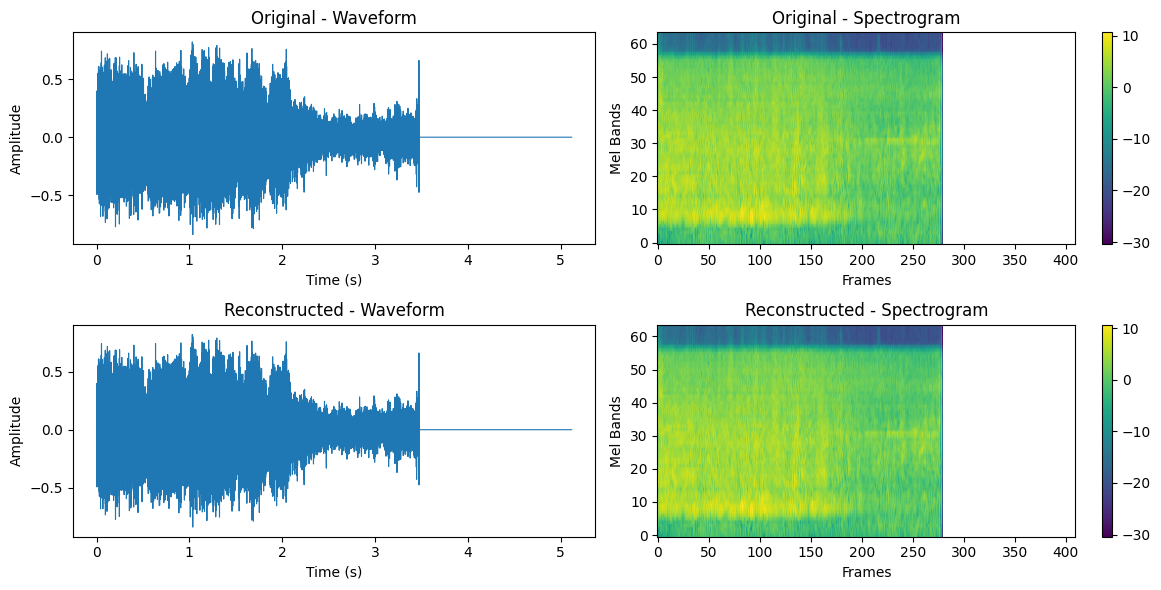

In [18]:
def plot_waveform_and_spectrogram(waveform, sr, title, ax1, ax2):

    ax1.plot(torch.arange(waveform.shape[1]) / sr, waveform.numpy().squeeze(), linewidth=0.8)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")

    transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)
    mel_spec = transform(waveform)

    im = ax2.imshow(mel_spec.log2().numpy().squeeze(), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Spectrogram")
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Mel Bands")
    plt.colorbar(im, ax=ax2)

waveform_orig, sr_orig = torchaudio.load(save_path)
waveform_recon, sr_recon = torchaudio.load(save_path)

assert sr_orig == sr_recon, "Sampling rates must match!"

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

plot_waveform_and_spectrogram(waveform_orig, sr_orig, "Original", axes[0, 0], axes[0, 1])
plot_waveform_and_spectrogram(waveform_recon, sr_recon, "Reconstructed", axes[1, 0], axes[1, 1])

plt.tight_layout()
plt.show()

In [19]:
Audio(save_path)

In [10]:
Audio(save_path)